In [1]:
# !pip install pandas-profiling

import numpy as np 
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Read the CSV file and display the first few rows
df = pd.read_csv('C:/Users/USER/Desktop/gold predic/gold_monthly_csv.csv')
print(f"Gold prices data has {df.shape[0]} rows and {df.shape[1]} columns.")
print(f"The date range of gold prices available is from {df.loc[:,'Date'][0]} to {df.loc[:,'Date'][len(df) - 1]}")
df.head()

Gold prices data has 847 rows and 2 columns.
The date range of gold prices available is from 1950-01 to 2020-07


,Date,Price
0,1950-01,34.73
1,1950-02,34.73
2,1950-03,34.73
3,1950-04,34.73
4,1950-05,34.73


In [5]:
# Create a new dataframe with monthly dates as the index
date_range = pd.date_range(start='1/1/1950', end='8/1/2020', freq='M')
df['month'] = date_range
df.drop('Date', axis=1, inplace=True)
df = df.set_index('month')
df.head()

,Price
month,
1950-01-31,34.73
1950-02-28,34.73
1950-03-31,34.73
1950-04-30,34.73
1950-05-31,34.73


In [9]:
# Show summary statistics of the gold prices
print("Summary statistics of gold prices:\n", df.describe())

Summary statistics of gold prices:
              Price
count   847.000000
mean    416.556906
std     453.665313
min      34.490000
25%      35.190000
50%     319.622000
75%     447.029000
max    1840.807000


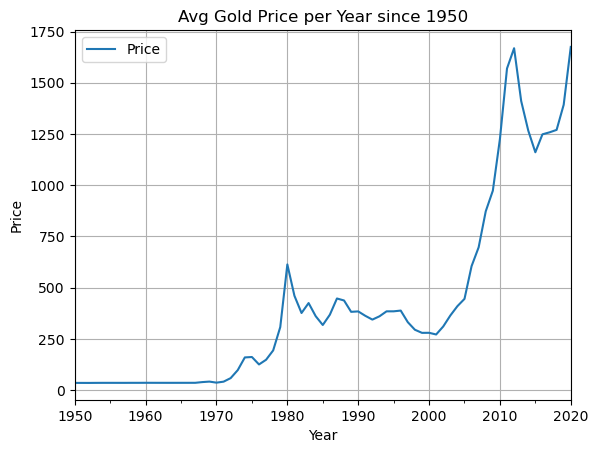

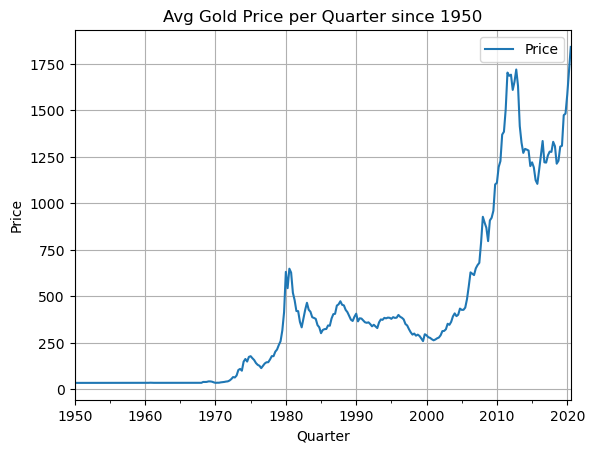

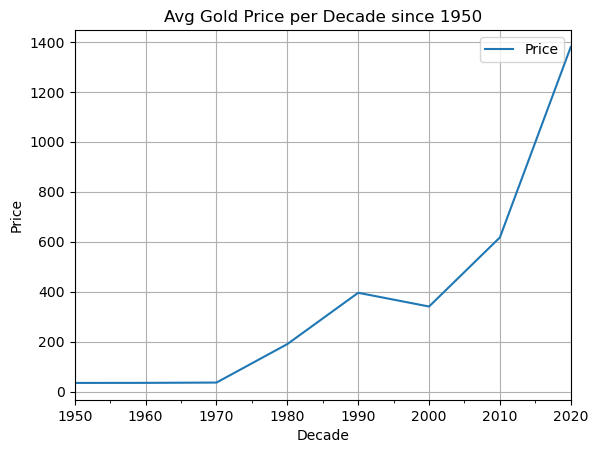

In [12]:
# Create yearly, quarterly, and decade summaries of the data
df_yearly_sum = df.resample('A').mean()
df_yearly_sum.plot()
plt.title('Avg Gold Price per Year since 1950')
plt.xlabel('Year')
plt.ylabel('Price')
plt.grid()

df_quarterly_sum = df.resample('Q').mean()
df_quarterly_sum.plot()
plt.title('Avg Gold Price per Quarter since 1950')
plt.xlabel('Quarter')
plt.ylabel('Price')
plt.grid()

df_decade_sum = df.resample('10Y').mean()
df_decade_sum.plot()
plt.title('Avg Gold Price per Decade since 1950')
plt.xlabel('Decade')
plt.ylabel('Price')
plt.grid()

In [13]:
# Show summary statistics of the gold prices
print("Summary statistics of gold prices:\n", df.describe())

Summary statistics of gold prices:
              Price
count   847.000000
mean    416.556906
std     453.665313
min      34.490000
25%      35.190000
50%     319.622000
75%     447.029000
max    1840.807000


The first few rows of the coefficient of variation data:
            Mean       Std  Cov_pct
month                              
1950   34.729167  0.002887     0.01
1951   34.717500  0.020057     0.06
1952   34.628333  0.117538     0.34
1953   34.879167  0.056481     0.16
1954   35.020000  0.082792     0.24


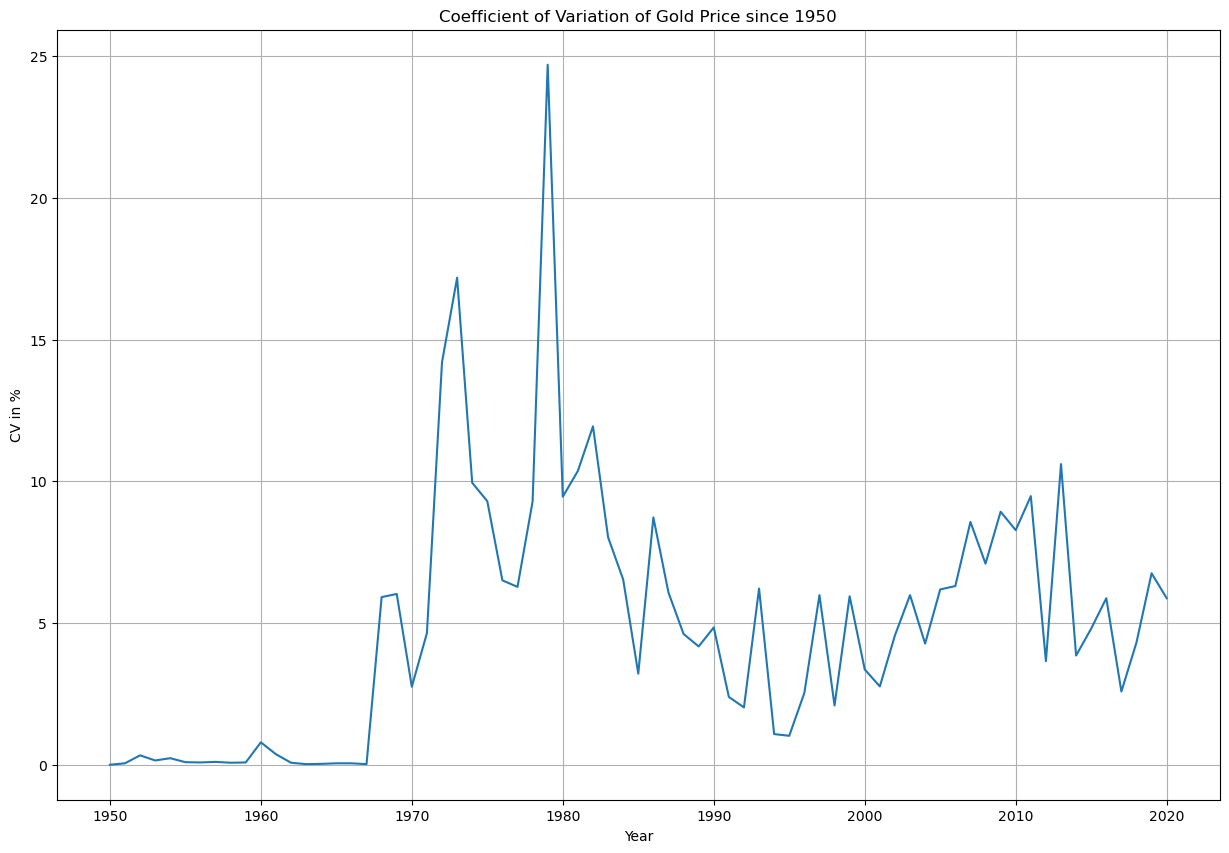

In [14]:
# Calculate the mean, standard deviation, and coefficient of variation (CV) for the data by year
df_1 = df.groupby(df.index.year).mean().rename(columns={'Price':'Mean'})
df_1 = df_1.merge(df.groupby(df.index.year).std().rename(columns={'Price':'Std'}), left_index=True, right_index=True)
df_1['Cov_pct'] = ((df_1['Std'] / df_1['Mean']) * 100).round(2)

# Plot the CV over time
fig, ax = plt.subplots(figsize=(15, 10))
df_1['Cov_pct'].plot()
plt.title('Coefficient of Variation of Gold Price since 1950')
plt.xlabel('Year')
plt.ylabel('CV in %')
plt.grid()

# Display the first few rows of the data
print('The first few rows of the coefficient of variation data:')
print(df_1.head())

In [15]:
# Split the dataset into training and testing sets based on a cutoff year
train = df[df.index.year <= 2015]
test = df[df.index.year > 2015]


# Check the shape of the training and testing sets
print("Training set shape:", train.shape)
print("Testing set shape:", test.shape)

# Checking for bias in the split
train_pct = len(train) / len(df) * 100
test_pct = len(test) / len(df) * 100
print("Percentage of data in training set:", round(train_pct, 2), '%')
print("Percentage of data in testing set:", round(test_pct, 2), '%')

# It is not necessarily biased to split the data this way. 
# However, it may depend on the specific problem and the goals of the analysis. 
# It is always a good practice to carefully consider the split and to test different split ratios to evaluate their impact on the model performance.

Training set shape: (792, 1)
Testing set shape: (55, 1)
Percentage of data in training set: 93.51 %
Percentage of data in testing set: 6.49 %


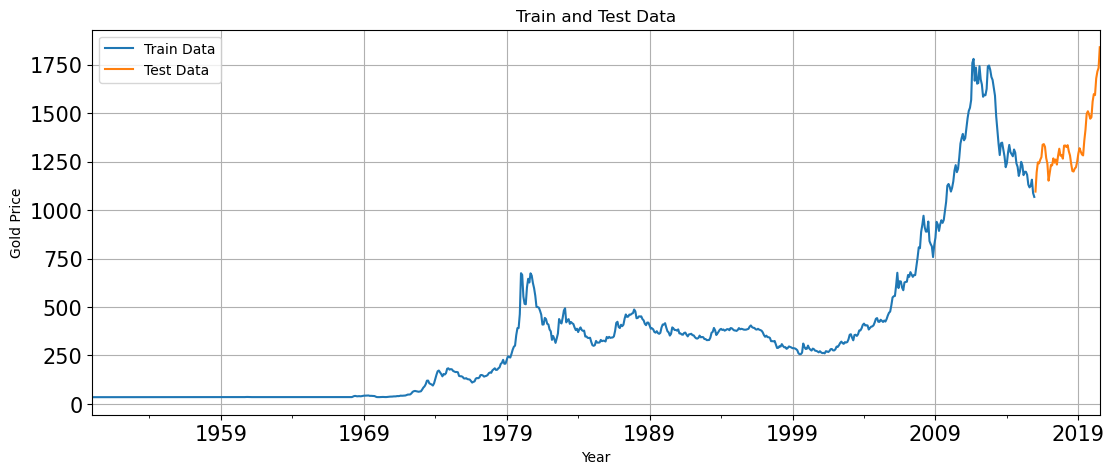

In [16]:
# Plot train and test data
train['Price'].plot(figsize=(13,5), fontsize=15)
test['Price'].plot(figsize=(13,5), fontsize=15)
plt.grid()
plt.legend(['Train Data', 'Test Data'])
plt.title('Train and Test Data')
plt.xlabel('Year')
plt.ylabel('Gold Price')
plt.show()


In [17]:
# Create time series for train and test data
train_time = [i+1 for i in range(len(train))]
test_time = [i+len(train)+1 for i in range(len(test))]
print(f"Train time series length: {len(train_time)}")
print(f"Test time series length: {len(test_time)}")

# Add time series as a feature to train and test data
LR_train = train.copy()
LR_test = test.copy()
LR_train['time'] = train_time
LR_test['time'] = test_time

Train time series length: 792
Test time series length: 55


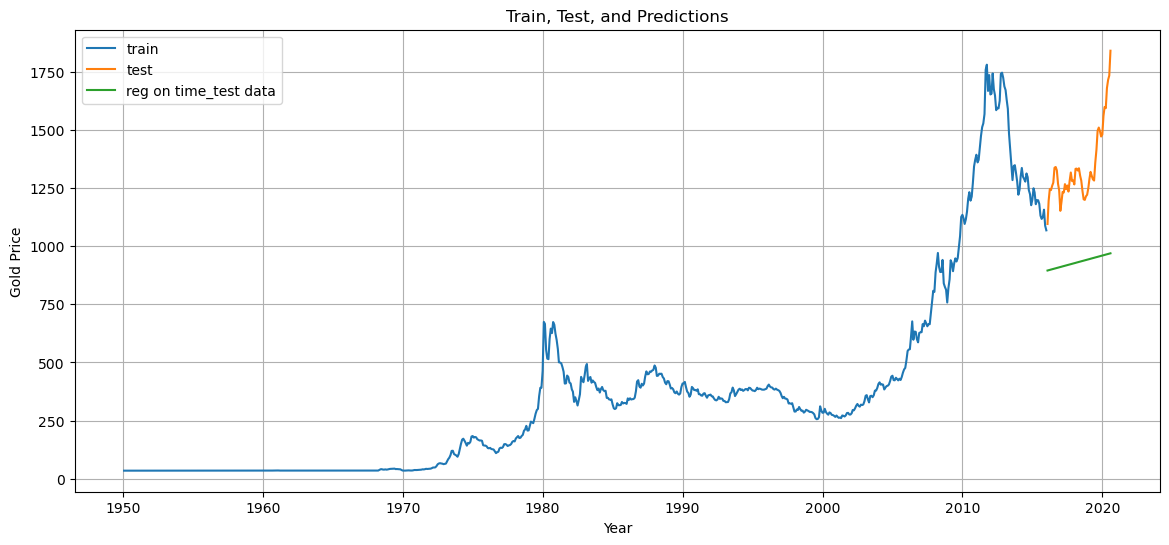

In [18]:
# Train a linear regression model on the train data using time as the independent variable
lr = LinearRegression()
lr.fit(LR_train[['time']], LR_train['Price'].values)

# Use the trained model to make predictions on the test data
test_predictions_model1 = lr.predict(LR_test[['time']])
LR_test['forecast'] = test_predictions_model1

# Plot the train data, test data, and predictions made by the linear regression model
plt.figure(figsize=(14,6))
plt.plot(train['Price'], label='train')
plt.plot(test['Price'], label='test')
plt.plot(LR_test['forecast'], label='reg on time_test data')
plt.legend(loc='best')
plt.grid()
plt.title('Train, Test, and Predictions')
plt.xlabel('Year')
plt.ylabel('Gold Price')
plt.show()

In [19]:
def mape(y_true, y_pred):
    """Calculate mean absolute percentage error (MAPE)"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE for the linear regression model
mape_model1_test = mape(test['Price'].values, test_predictions_model1)
print(f"MAPE for Regression on Time model on test data: {mape_model1_test:.3f}%")

MAPE for Regression on Time model on test data: 29.760%


In [20]:
# Create results dataframe to store MAPE values for different models
results = pd.DataFrame({'Test MAPE (%)': [mape_model1_test]}, index=['Regression on Time'])
results

,Test MAPE (%)
Regression on Time,29.759658


In [21]:
# Create naive model
naive_train = train.copy()
naive_test = test.copy()
naive_test['naive'] = np.asarray(train['Price']) [len(np.asarray(train['Price'])) - 1]
naive_test['naive'].head()

month
2016-01-31    1068.317
2016-02-29    1068.317
2016-03-31    1068.317
2016-04-30    1068.317
2016-05-31    1068.317
Name: naive, dtype: float64

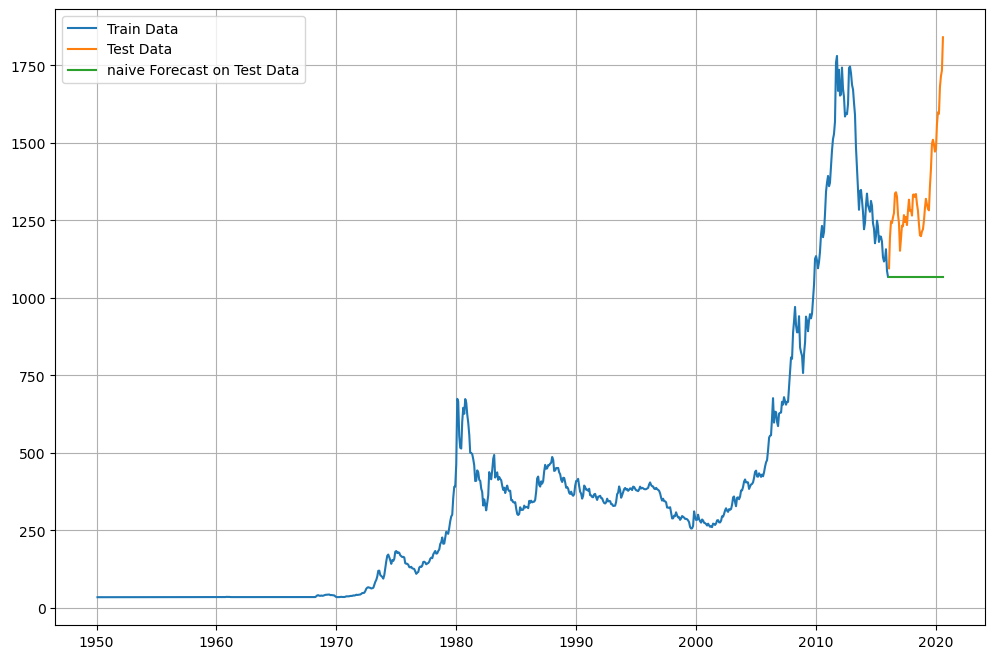

In [22]:
# Plot the train, test, and naive forecast on test data
plt.figure(figsize=(12,8))
plt.plot(naive_train['Price'], label='Train Data')
plt.plot(test['Price'], label='Test Data')
plt.plot(naive_test['naive'], label='naive Forecast on Test Data')
plt.legend(loc='best')
plt.grid()

In [23]:
# Calculate MAPE for naive forecast model
mape_model2_test = mape(test['Price'].values, naive_test['naive'].values)
print('MAPE for naive Forecast model is %3.3f%%' % mape_model2_test)

# Update the dataframe with the MAPE result for the naive forecast model
resultsDf_2 = pd.DataFrame({'Test MAPE (%)': [mape_model2_test]}, index=['naiveForecast'])
results = pd.concat([results,resultsDf_2])

# Display the dataframe with the MAPE results for both models
results

MAPE for naive Forecast model is 19.385%


,Test MAPE (%)
Regression on Time,29.759658
naiveForecast,19.384586


In [24]:
# Perform exponential smoothing with additive trend and additive seasonality
final_model = ExponentialSmoothing(df, trend='additive', seasonal='additive').fit(
    smoothing_level=0.4, smoothing_trend=0.3, smoothing_seasonal=0.6)

# Calculate mean absolute percentage error (MAPE) of the fitted values
mape_final_model = mape(df['Price'].values, final_model.fittedvalues)
print('MAPE of final model: %.3f%%' % mape_final_model)

MAPE of final model: 17.236%


In [25]:
# Generate forecast using the final model
prediction = final_model.forecast(steps=len(test))

# Create a dataframe to store the prediction and confidence intervals
pred_df = pd.DataFrame({
    'lower_CI': prediction - 1.96 * np.std(final_model.resid, ddof=1),
    'prediction': prediction,
    'upper_CI': prediction + 1.96 * np.std(final_model.resid, ddof=1)
})
# Export the predictions into a csv file.
pred_df.to_csv('gold_price_predictions.csv', index=True, index_label='Month') 

print('Prediction and confidence intervals:')
pred_df

Prediction and confidence intervals:


,lower_CI,prediction,upper_CI
2020-08-31,1684.713703,1792.864676,1901.015650
2020-09-30,1615.291065,1723.442039,1831.593012
2020-10-31,1538.543199,1646.694172,1754.845146
2020-11-30,1476.724385,1584.875359,1693.026332
2020-12-31,1459.285045,1567.436019,1675.586992
2021-01-31,1514.369725,1622.520699,1730.671672
2021-02-28,1545.301712,1653.452686,1761.603659
2021-03-31,1556.713533,1664.864506,1773.015479
2021-04-30,1648.260721,1756.411695,1864.562668
2021-05-31,1694.179281,1802.330255,1910.481228


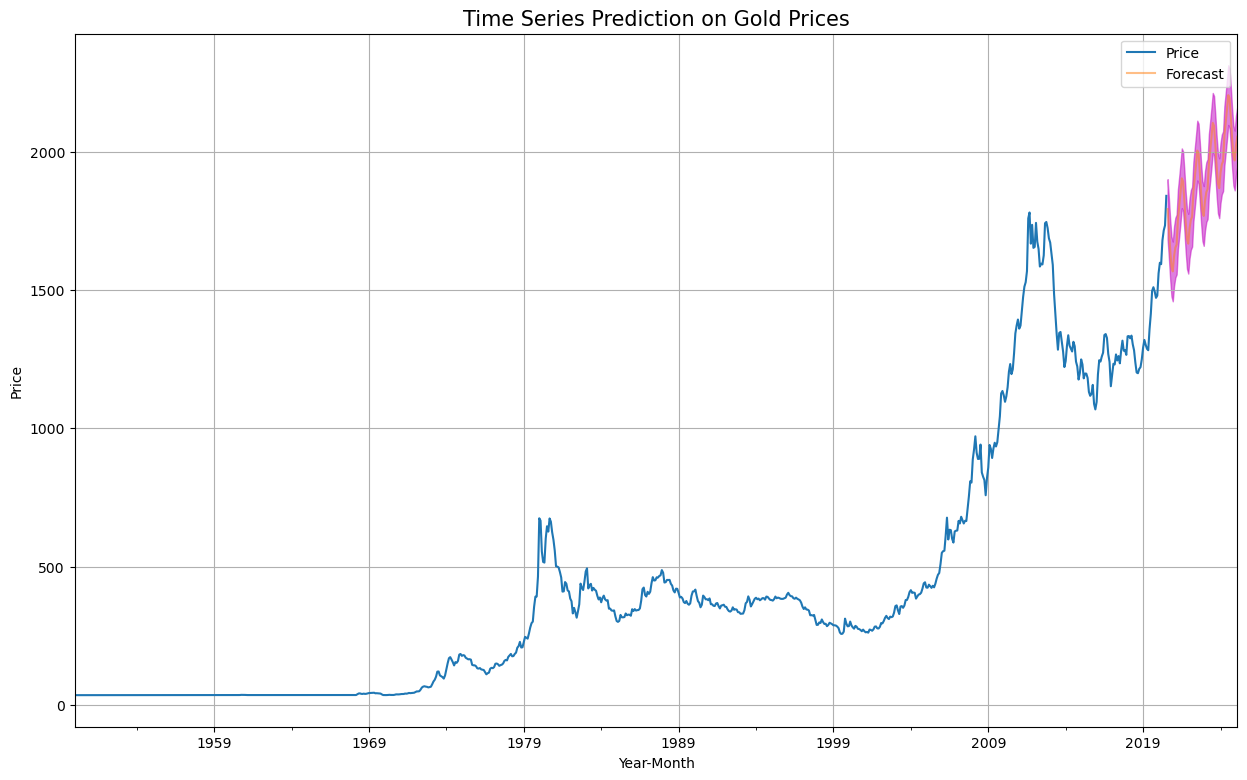

<Figure size 640x480 with 0 Axes>

In [23]:
# Plot actual and predicted values with confidence intervals
axis = df.plot(label='Actual', figsize=(15,9))
pred_df['prediction'].plot(ax=axis, label='Forecast', alpha=0.5)
axis.fill_between(pred_df.index, pred_df['lower_CI'], pred_df['upper_CI'], color='m', alpha=0.5)
axis.set_xlabel('Year-Month')
axis.set_ylabel('Price')
plt.title('Time Series Prediction on Gold Prices',fontsize=15)
plt.legend(loc='best')
plt.grid()
plt.show()

# Save plot as png
plt.savefig('gold_price_predictions.png')

## References
- Kaggle Dataset: [Monthly Gold Price](https://www.kaggle.com/datasets/nhiyen/monthly-gold-price)
- Github Repo - [HERE](https://github.com/yennhi95zz/predict-gold-prices)
- Kaggle Project - [HERE](https://www.kaggle.com/nhiyen/time-series-prediction-on-gold-prices)
- Detail Explanation about the code on [MEDIUM]([https://medium.com/@yennhi95zz/unleashing-the-power-of-e-commerce-sales-analysis-a-case-study-4c64871a86ee](https://medium.com/@yennhi95zz/time-series-prediction-on-gold-prices-a826fc2ead0c))